In [47]:
import pandas as pd
df = pd.read_csv('disease_urls.csv')

#df.head()

In [7]:
df.head()

,disease_label,url,heading
0,diabetes,https://www.healthline.com/health/diabetes,"Diabetes: Symptoms, Causes, Treatment, Prevent..."
1,depression mental or depressive disorder,https://www.healthline.com/health/clinical-dep...,"Depression Statistics: Types, Symptoms, Treatm..."
2,coronary arteriosclerosis or coronary heart di...,https://www.healthline.com/health/coronary-art...,"Coronary Artery Disease: Causes, Symptoms, and..."
3,pneumonia,https://www.healthline.com/health/pneumonia,"Pneumonia: Symptoms, Causes, Treatment, and More"
4,asthma,https://www.healthline.com/health/asthma,"Asthma: Symptoms, Treatment, and Prevention - ..."


In [ ]:
# # Assuming 'df' is your DataFrame
# df = df.sample(frac=1)  # Shuffle all rows
# # Calculate the number of rows that correspond to 15%
# num_rows = int(0.15 * len(df))
# # Store 15% of dataset in another DataFrame
# df_15_percent = df[:num_rows]
# df_15_percent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 69 to 112
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   disease_label  20 non-null     object
 1   url            20 non-null     object
 2   heading        20 non-null     object
dtypes: object(3)
memory usage: 640.0+ bytes


In [82]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.action_chains import ActionChains
from tqdm.notebook import tqdm
import time
import random
import re
import csv
import traceback
from bs4 import BeautifulSoup

def simulate(actions, driver): #simulate human wait and mouse movement
        time.sleep(random.uniform(1.5,2.1))
        actions.move_by_offset(random.randint(150, 250), random.randint(150, 250)).perform()
        actions.move_to_element_with_offset(driver.find_element(By.TAG_NAME, 'body'), 0, 0).perform()

chrome_options = Options()
chrome_options.add_argument("--disable-blink-features=AutomationControlled") #Remove Navigator.Webdriver Flag in Selenium
chrome_options.add_argument("--incognito") # so that they can't track with cookie , session

#chrome_options.add_argument('--blink-settings=imagesEnabled=false') #data save, time save


#user agent for : linux, macos, win 7 ,8, 8.1, avoiding 10 cos mine, try 11 too
ua_list = [#"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
            #"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
            "Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36", #win <8.1 doesnt officialy support chrome 116
            "Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
            "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36"]

In [73]:
def initialize_csv():
    with open("healifyML-language-model-QA-dataset.csv", "a", newline="" , encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["disease", "question", "answer"])

def remove_links(selenium_element): #return_mode:str
    soup = BeautifulSoup( selenium_element.get_attribute('outerHTML'), 'html.parser')
    a_tags = soup.find_all('a')
    for a in a_tags:
        del a['href'] # a['href'] = ''
        a['style'] = 'color: black; text-decoration: none; cursor: default;' #color: inherit   
    
    return str(soup)
    #print(str(soup))

In [74]:
initialize_csv()

In [84]:
#chrome_options.add_experimental_option("detach", True) #just to obsereve

# {web page search keyword : label} pair
# dataset_labels = {"symptom": "symptoms", 
#                    "cause" : "cause",
#                    "risk": "risks", 
#                    "complication": "complications", 
#                    "treatment": "treatment", 
#                    "diagnos": "diagnosis", 
#                    "prevent": "prevention"}

for idx, row in  df.iterrows(): #df.url #tqdm()
    
    url = row['url']
    ua_choice = random.choice(ua_list)
    chrome_options.add_argument(f'--user-agent={ua_choice}')
    driver = webdriver.Chrome(options=chrome_options)
    actions = ActionChains(driver)

    try:
        driver.get(url)
        simulate(actions,driver)
        while(random.randint(0,1)): 
            driver.maximize_window() 
            break  
        
        disease = row['disease_label']

        #intro row entry:
        intro_question = f'what is {disease}? Tell me about {disease}? What kind of disease is {disease}? Can you elaborate on {disease}? What can you tell me about {disease}? Could you describe what {disease} is? I’d like to know more about {disease}. Can you help? What information do you have on {disease}? Could you provide information on {disease}?'
        intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
        intro_content = [ p_element.text     for p_element in intro_content]
        ans = '\n'.join(intro_content)
        #print(ans)
        
        #classification_label = "what's {disease}"

        with open("healifyML-language-model-QA-dataset.csv", "a", newline="" , encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([disease, intro_question, ans])

##################

        # #remaining rows: make dataset_queries{} keyword: all alt questions like f'what is {disease}? Tell me about{disease}? What kind of disease is...' 
        # page_queries = driver.find_element(By.ID, 'tab-bar-0').find_elements(By.TAG_NAME, "a")
        # page_queries = [ element.text.lower()  for element in page_queries]
        
        # #for i in page_queries: print(i.text)

        # relevant_queries = [ serach_key     for question in page_queries 
        #                                         for serach_key in dataset_labels if serach_key in question ]# if query in page_queries]
        # print(relevant_queries)

######################

        query_contents = driver.find_elements(By.CSS_SELECTOR, 'div.css-0')

        for content_div in query_contents:
            #print(content_div.get_attribute('outerHTML'))
            heading = content_div.find_element(By.TAG_NAME, "h2").text.lower()
            question = 'for '+ disease + ', ' + heading + '?'
            #print(question)
            
            driver.execute_script("""
                const element = arguments[0];
                const question_heading = element.getElementsByTagName('div')[0]; 
                element.removeChild(question_heading);
            """, content_div)
            #removeChild can remove only direct children
            answer = content_div.text
            #print(answer+'\n')
            
            
            with open("healifyML-language-model-QA-dataset.csv", "a", newline="" , encoding="utf-8") as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow([disease, question, answer])

        simulate(actions, driver)

        print('completed ',idx+1)
    
    except Exception as e:
        print(url)
        with open('LLM scrap track.txt', 'a') as f:
            # Write the data to the file
            f.write(url + '\n')  # '\n' is used to add a new line after writing the data

        traceback.print_exc()
        driver.quit()
        #append url in file
        #driver.quit()
        continue
        #continue

completed  0
completed  1
completed  2
completed  3
completed  4
completed  5
https://www.healthline.com/health/anemia


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  7
completed  8
completed  9
https://www.healthline.com/health/hiv-aids


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  11
completed  12
https://www.healthline.com/health/septicemia


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  14
completed  15
completed  16
completed  17
completed  18
completed  19
completed  20
completed  21
completed  22
https://www.healthline.com/health/peripheral-vascular-disease


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  24
https://www.healthline.com/health/hyperlipidemia


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  26
completed  27
completed  28
completed  29
completed  30
completed  31
https://www.healthline.com/health/bronchitis


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  33
https://www.healthline.com/health/stroke/signs-symptoms-tia-mini-stroke


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

https://www.healthline.com/health/cancer/adenocarcinoma-symptoms


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  36
completed  37
completed  38
https://www.healthline.com/health/prostate-cancer


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  40
completed  41
completed  42
https://www.healthline.com/health/gastritis


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  44
completed  45
completed  46
completed  47
completed  48
completed  49
completed  50
completed  51
completed  52
completed  53
completed  54
completed  55
https://www.healthline.com/health/parkinsons


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  57
https://www.healthline.com/health/type-2-diabetes/hyperglycemia


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  59
completed  60
completed  61
completed  62
completed  63
completed  64
https://www.healthline.com/health/uterine-fibroids


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  66
completed  67
completed  68
completed  69
completed  70
completed  71
completed  72
https://www.healthline.com/health/viral-gastroenteritis


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  74
completed  75
completed  76
https://www.healthline.com/health/liver-cancer


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  78
completed  79
completed  80
completed  81
completed  82
completed  83
completed  84
completed  85
completed  86
completed  87
completed  88
completed  89
completed  90
completed  91
completed  92
completed  93
completed  94
completed  95
completed  96
completed  97
completed  98
completed  99
https://www.healthline.com/health/high-blood-pressure-hypertension


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 22, in <module>
    simulate(actions,driver)
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\3385559533.py", line 16, in simulate
    actions.move_by_offset(random.randint(150, 250), random.randint(150, 250)).perform()
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\common\action_chains.py", line 103, in perform
    self.w3c_actions.perform()
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\common\actions\action_builder.py", line 96, in perform
    self.driver.execute(Command.W3C_ACTIONS, enc)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    r

completed  101
completed  102
completed  103
completed  104
completed  105
https://www.healthline.com/health/chronic-urinary-tract-infection


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  107
completed  108
completed  109
completed  110
completed  111
https://www.healthline.com/health/gastric-cancer


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

https://www.healthline.com/health/hiv-aids


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  114
completed  115
completed  116
completed  117
completed  118
completed  119
completed  120
completed  121
completed  122
completed  123
https://www.healthline.com/health/schizophrenia


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  125
completed  126
completed  127
completed  128
completed  129
completed  130
completed  131
https://www.healthline.com/health/fluid-around-heart


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 31, in <module>
    intro_content = driver.find_element(By.CSS_SELECTOR, 'div.css-1u22pos').find_elements(By.TAG_NAME, "p")   #(By.CSS_SELECTOR, 'p.css-1rnzyga')
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 739, in find_element
    return self.execute(Command.FIND_ELEMENT, {"using": by, "value": value})["value"]
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.css-

completed  133
https://www.healthline.com/health/bronchospasm


Traceback (most recent call last):
  File "C:\Users\ishraq\AppData\Local\Temp\ipykernel_10628\427766249.py", line 21, in <module>
    driver.get(url)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 354, in get
    self.execute(Command.GET, {"url": url})
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 345, in execute
    self.error_handler.check_response(response)
  File "g:\dokkho project ongoing\final-env\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=116.0.5845.188)
Stacktrace:
	GetHandleVerifier [0x00007FF6ABD552A2+57122]
	(No symbol) [0x00007FF6ABCCEA92]
	(No symbol) [0x00007FF6ABB9E3AB]
	(No symbol) [0x00007FF6ABB8C01A]
	(No symbol

completed  135
completed  136


In [85]:
driver.quit()

In [15]:
soup = BeautifulSoup(
'''
<div class="css-0"><span style="font-size:0;line-height:0"></span><div><h2><div><a class="chartbeat-section" name="location-and-symptoms" style="color: black; text-decoration: none; cursor: default;">Where do metastatic cancers commonly spread to, and what are the symptoms?</a></div></h2></div><span style="font-size:0;line-height:0"></span><p class="responsive">Cancer can spread almost anywhere, but different types of cancer tend to spread to certain places. The following are the <hl-trusted-source class="css-12hs4c5" rationale="Governmental authority" source="National Cancer Institute "><a class="content-link css-5r4717" rel="noopener noreferrer" style="color: black; text-decoration: none; cursor: default;" target="_blank">most common<span class="css-1mdvjzu icon-hl-trusted-source-after"><span class="sro">Trusted Source</span></span></a><span></span></hl-trusted-source> sites of metastasis, according to the National Cancer Institute:</p><div class="scrollTable css-1iwt4bv"><table class="responsive css-1pp4cxb"><tbody><tr><th scope="col">Metastatic cancer type</th><th scope="col">Main sites of metastasis</th></tr><tr><td><a class="content-link css-5r4717" style="color: black; text-decoration: none; cursor: default;">bladder</a></td><td>bone, liver, lung</td></tr><tr><td><a class="content-link css-5r4717" style="color: black; text-decoration: none; cursor: default;">breast</a></td><td>bone, brain, liver, lung</td></tr><tr><td><a class="content-link css-5r4717" style="color: black; text-decoration: none; cursor: default;">colon</a></td><td>liver, lung, peritoneum (the membrane that lines your abdominal cavity)</td></tr><tr><td><a class="content-link css-5r4717" style="color: black; text-decoration: none; cursor: default;">kidney</a></td><td>adrenal gland, bone, brain, liver, lung</td></tr><tr><td><a class="content-link css-5r4717" style="color: black; text-decoration: none; cursor: default;">lung</a></td><td>adrenal gland, bone, brain, liver, the other lung</td></tr><tr><td><a class="content-link css-5r4717" style="color: black; text-decoration: none; cursor: default;">melanoma</a></td><td>bone, brain, liver, lung, skin, muscle</td></tr><tr><td><a class="content-link css-5r4717" style="color: black; text-decoration: none; cursor: default;">ovarian</a></td><td>liver, lung, peritoneum</td></tr><tr><td><a class="content-link css-5r4717" style="color: black; text-decoration: none; cursor: default;">pancreatic</a></td><td>liver, lung, peritoneum</td></tr><tr><td><a class="content-link css-5r4717" style="color: black; text-decoration: none; cursor: default;">prostate</a></td><td>adrenal gland, bone, liver, lung</td></tr><tr><td><a class="content-link css-5r4717" style="color: black; text-decoration: none; cursor: default;">rectal</a></td><td>liver, lung, peritoneum</td></tr><tr><td><a class="content-link css-5r4717" style="color: black; text-decoration: none; cursor: default;">stomach</a></td><td>liver, lung, peritoneum</td></tr><tr><td><a class="content-link css-5r4717" style="color: black; text-decoration: none; cursor: default;">thyroid</a></td><td>bone, liver, lung</td></tr><tr><td><a class="content-link css-5r4717" style="color: black; text-decoration: none; cursor: default;">uterine</a></td><td>bone, liver, lung, peritoneum, vagina</td></tr></tbody></table></div><h3 class="responsive">General symptoms of metastasis</h3><p class="responsive">Fatigue and weight loss are among the general symptoms of metastatic cancer. Other symptoms depend on the site of metastasis, such as: </p><ul class="responsive"><li><strong>Bone:</strong> pain, easily fractured bones</li><li><strong>Brain:</strong> headache, dizziness, vision problems, seizures</li><li><strong>Lung:</strong> shortness of breath, cough, chest pain</li><li><strong>Liver:</strong> jaundice (yellowing of the skin and eyes), bloating, abdominal pain</li></ul><p class="responsive">The number and size of tumors can also affect the symptoms.</p><div class="css-1sxbpyw" data-adbridg-ad-class-invalid="false(hl-incontent)" id="hl-incontent-video-ad"></div><div class="css-1h5aco8" id="div-gpt-ad-out-of-page"></div></div>
''')
for element in soup.recursiveChildGenerator():
    if element.name:
        print(element.name, element.text + ' \n')

div Where do metastatic cancers commonly spread to, and what are the symptoms?Cancer can spread almost anywhere, but different types of cancer tend to spread to certain places. The following are the most commonTrusted Source sites of metastasis, according to the National Cancer Institute:Metastatic cancer typeMain sites of metastasisbladderbone, liver, lungbreastbone, brain, liver, lungcolonliver, lung, peritoneum (the membrane that lines your abdominal cavity)kidneyadrenal gland, bone, brain, liver, lunglungadrenal gland, bone, brain, liver, the other lungmelanomabone, brain, liver, lung, skin, muscleovarianliver, lung, peritoneumpancreaticliver, lung, peritoneumprostateadrenal gland, bone, liver, lungrectalliver, lung, peritoneumstomachliver, lung, peritoneumthyroidbone, liver, lunguterinebone, liver, lung, peritoneum, vaginaGeneral symptoms of metastasisFatigue and weight loss are among the general symptoms of metastatic cancer. Other symptoms depend on the site of metastasis, such 

In [3]:
import pandas as pd
df = pd.read_csv('healifyML-language-model-QA-dataset.csv', encoding='utf-8', engine='python')#, on_bad_lines='skip', sep='delimiter')
df.head()
df.isnull().sum()



disease      0
question     0
answer      13
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isnull().sum()

disease     0
question    0
answer      0
dtype: int64

In [7]:
df.isnull().sum()
nan_rows = df[df.isnull().any(axis=1)]
display(nan_rows)

df.drop(df[df['disease'] == 'hepatitis B'].index, inplace=True)

display( df[df['disease'] == 'hepatitis B']) #hepatitis B  dependence


,disease,question,answer


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152 entries, 0 to 1166
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   disease   1152 non-null   object
 1   question  1152 non-null   object
 2   answer    1152 non-null   object
dtypes: object(3)
memory usage: 68.3+ KB


In [9]:
#save df to csv. save as csv:
df.to_csv('data.csv', index=False, encoding='utf-8')

In [10]:
ans_len = []
def collect_len (text):
    try: ans_len.append(len(text))
    except: pass 

#df.answer.apply(type)
df.question.apply(collect_len) #ans_len.append(len(text)) )

0       None
1       None
2       None
3       None
4       None
        ... 
1162    None
1163    None
1164    None
1165    None
1166    None
Name: question, Length: 1152, dtype: object

In [13]:
ans_len

import statistics
median_value = statistics.median(ans_len)
median_value

50.0

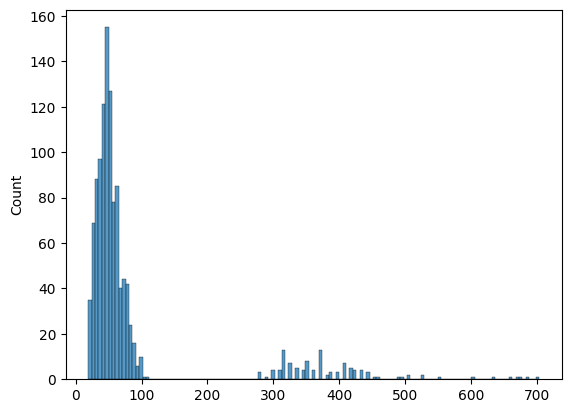

In [14]:
len(ans_len), ans_len
import statistics
statistics.median(ans_len)

import seaborn as sns
import matplotlib.pyplot as plt
# Create histogram
sns.histplot(ans_len, kde=False)

# Show plot
plt.show()

In [104]:
pip install seaborn


  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached matplotlib-3.5.3-cp37-cp37m-win_amd64.whl (7.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Obtaining dependency information for kiwisolver>=1.0.1 from https://files.pythonhosted.org/packages/27/b5/c548a1f1cef3fb9af3f59d6fc4259aa17c48403680c33435ca675aae2b30/kiwisolver-1.4.5-cp37-cp37m-win_amd64.whl.metadata
  Using cached Pillow-9.5.0-cp37-cp37m-win_amd64.whl (2.5 MB)
  Obtaining dependency information for pyparsing>=2.2.1 from https://files.pythonhosted.org/packages/39/92/8486ede85fcc088f1b3dba4ce92dd29d126fd96b0008ea213167940a2475/pyparsing-3.1.1-py3-none-any.whl.metadata
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
   ---------------------------------------- 55.8/55.8 kB 584.1 kB/s eta 0:00:00
Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
